*****************************************************************
#  Research paper
- Authors: Paul Koks, Izzie He, Lisanne van Vliet, Sam Slotemaker
- TAs: Sandro Barres-Hamers, Alexander Schmatz, Márton Bodó and Danae Mitsea.
*****************************************************************

## Installing the needed packages
The following 2 cells install and import the needed packages


In [ ]:
!pip install nltk
!pip install scikit-learn

In [1]:
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/samsloot/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Store all comments from the CSV files with their corresponding movie ID
This cell gets all data from the comment CSVs and puts it inside a map by its movie ID, so it can later be easily extracted

In [2]:
import csv
import os

directory = 'datasets/comments'
comments_by_movie_id = {}
# all fileNames must be [movieId].csv, where movieId is the ID from the dataset row, to make this work
files_parsed = 0
for filename in os.listdir(directory):
    if filename.endswith('.csv'): 
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r') as file:
            csv_reader = csv.DictReader(file)
            data = [row for row in csv_reader]
            fileName = filename.split('.')[0];
            comments_by_movie_id[fileName] = data
            files_parsed += 1

print(f"All comments are parsed from {files_parsed} files and are stored inside the comments_by_movie_id variable!")

All comments are parsed from 40 files and are stored inside the comments_by_movie_id variable!


## Store the average sentiment of the trailer comments
This cell will analyse all comments and store their sentiment score

In [3]:
sid = SentimentIntensityAnalyzer()

sentiment_by_movie_id = {}

for movieId, comments in comments_by_movie_id.items():
    sentiment_total = 0
    for comment in comments:
        sentence = comment['text']
        ss = sid.polarity_scores(sentence)
        sentiment_total += ss['compound']
        average_sentiment = 0;

    # some comment files are broken so added this check to not break the code
    if len(comments) != 0:
        average_sentiment = sentiment_total / len(comments)
    else: 
        print('no comments found for:')
        print(movieId)
        
    sentiment_by_movie_id[movieId] = average_sentiment

print("All sentiments are analysed and stored inside the sentiment_by_movie_id variable!")

no comments found for:
739405
no comments found for:
840326
All sentiments are analysed and stored inside the sentiment_by_movie_id variable!


## Analysis
The cell below takes our 40 movies, then, for every movie it plots it against the trailer score number 

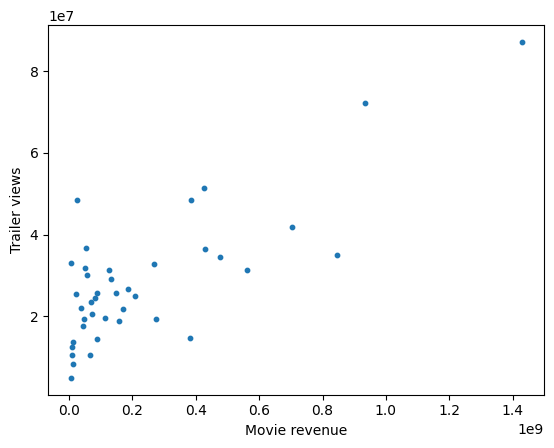

In [5]:
with open('datasets/40MoviesDataSet.csv', 'r') as file:
    csv_reader = csv.DictReader(file)
    movie_data = [row for row in csv_reader]

def getTrailerViews(movie):
    viewCount = int(movie['viewCount'])
    return viewCount

def getMovieBoxOffice(movie):
    return int(movie['revenue'])

    
box_office = [getMovieBoxOffice(movie) for movie in movie_data]
trailer_views = [getTrailerViews(movie) for movie in movie_data]

plt.scatter(box_office, trailer_views, s=10)

plt.xlabel("Movie revenue")
plt.ylabel("Trailer views")

plt.show()

### Correlation
The cell below takes the movie box office & trailer score and checks if there is a correlation between the two

In [6]:
# Calculate Pearson correlation
correlation = np.corrcoef(box_office, trailer_views)[0, 1]
print(f"correlation number is {correlation}.")

correlation number is 0.7752875522335961.


The cell below also take the trailer like ratio and sentiment score into account and shows a correlation_matrix between the variables

In [9]:
import pandas as pd
from sklearn.linear_model import LinearRegression

def getSentimentScore(movie):
    sentimentScore = sentiment_by_movie_id[movie['id']]
    return sentimentScore
    
def getTrailerLikeRatio(movie):
    return int(movie['likeCount']) / int(movie['viewCount'])

trailer_like_ratios = [getTrailerLikeRatio(movie) for movie in movie_data]
trailer_sentiment_score = [getSentimentScore(movie) for movie in movie_data]

x = np.column_stack((trailer_views, trailer_like_ratios, trailer_sentiment_score))
y = np.array(box_office)

# Fit a linear regression model
model = LinearRegression()
model.fit(x, y)

# # Coefficients indicate the influence of each variable
# print("Coefficients:", model.coef_)
# print("Intercept:", model.intercept_)
# print("R-squared:", model.score(x, y))  # Measure of how well the model fits


# Create a dataframe for easier correlation analysis
data = pd.DataFrame({
    "box office": box_office,
    "trailer views": trailer_views,
    "like ratio": trailer_like_ratios,
    "sentiment score": trailer_sentiment_score,
})

# Compute the correlation matrix
correlation_matrix = data.corr()
print(correlation_matrix)


                 box office  trailer views  like ratio  sentiment score
box office         1.000000       0.775288    0.471155         0.282987
trailer views      0.775288       1.000000    0.143644         0.252166
like ratio         0.471155       0.143644    1.000000         0.266497
sentiment score    0.282987       0.252166    0.266497         1.000000


We can also visualise this correlation matrix with a heatmap

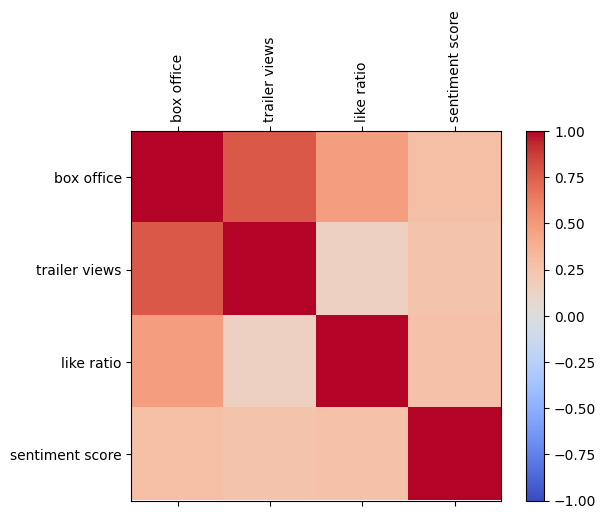

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlation_matrix,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()